In [1]:
import matplotlib.pyplot as plt
import numpy as np

#models
import shiftNMF_frozen as Hybrid
import shiftNMFDiscTau as DiscTau
import torchNMF as standard

from helpers.generators import *

In [2]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 7, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V.real

np.random.seed(42)

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
W = np.append(W, [[1,0,0]], axis=0)
W = np.append(W, [[0,1,0]], axis=0)
W = np.append(W, [[0,0,1]], axis=0)
N = N+3

#W = np.random.rand(N, d)
shift = 500
# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
# tau = np.zeros((N,d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [2000, 5000, 8000]
std = [100, 300, 50]
t = np.arange(0, 10000, 1)

H = np.array([multiplet(t, 1, m, s, 100) for m, s in list(zip(mean, std))])
# H_lorentz = np.array([m(m, s, t) for m, s in list(zip(mean, std))])
H_duplet = np.array([multiplet(t, 2, m, s, 1000) for m, s in list(zip(mean, std))])

X = shift_dataset(W, H, tau)
# X_lorentz = shift_dataset(W, H_lorentz, tau)
X_duplet = shift_dataset(W, H_duplet, tau)


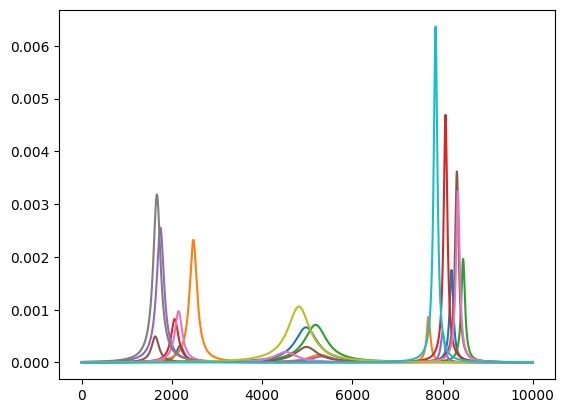

In [3]:
plt.plot(X.T)
plt.show()

In [4]:
print('Fitting Standard NMF')
NMF = standard.NMF(X, 3, lr=0.1, alpha=1e-6)
_,_, running_loss = NMF.fit(verbose=True, return_loss=True)

print('\n Fitting Discrete Tau NMF')
discTau = DiscTau.ShiftNMF(X, 3, lr=0.1, alpha=1e-6)
_,_,_, running_loss_disc = discTau.fit(verbose=True, return_loss=True, max_iter=1000, tau_iter=0)

print('\n Fitting Hybrid NMF')
hybrid = Hybrid.ShiftNMF(X, 3, lr=0.1, alpha=1e-6)
_,_,_, running_loss_hybrid = hybrid.fit(verbose=True, return_loss=True, max_iter=1000, tau_iter=0)


Fitting Standard NMF


c:\Users\lucas\Documents\UNI\Bachelorprojekt\torchNMF.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.lossfn = frobeniusLoss(torch.tensor(self.X))


epoch: 709, Loss: 0.33338926981963696
 Fitting Discrete Tau NMF
epoch: 1000, Loss: 0.00496502488989919, Tau: 2139.03808593757555
 Fitting Hybrid NMF


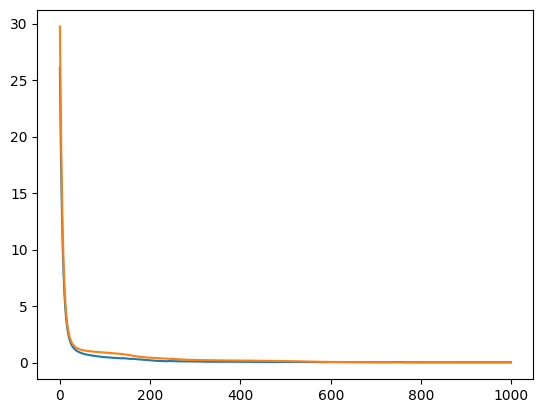

In [5]:
plt.plot(running_loss_hybrid, label='Hybrid')
plt.plot(running_loss_disc, label='Discrete Tau')
plt.show()